In [30]:
import numpy as np
import matplotlib.pyplot as plt
import qutip
import time
import Pulser
from pulser import Pulse, Sequence, Register, Simulation
from pulser.waveforms import ConstantWaveform, RampWaveform, CustomWaveform
from pulser.devices import Chadoq2
from pulser.simresults import SimulationResults

from scipy.optimize import minimize
from scipy.interpolate import PchipInterpolator
from skopt import gp_minimize
from skopt import callbacks
from skopt.utils import cook_initial_point_generator

In [133]:
U_0 = 2 * np.pi * 2.0

Omega_max = 1.0 * U_0 
delta_0 = -2.0 * U_0
delta_f = 1.8 * U_0 
m = 5 
T= 5000

N = 7
W = 0.6

time_domain = np.linspace(0,T,T)
lhs2 = cook_initial_point_generator("lhs", criterion="maximin")

In [134]:
def reg(N, W):
    U =  [U_0 * (1 + np.random.uniform(-W, W)) for _ in range(N)]
    W = [u/U_0-1 for u in U]
    def R(j):
        return Chadoq2.rydberg_blockade_radius(U[j]) 

    # Build Register:

    coords = np.array([(sum(R(k) for k in range(i)), 0.) for i in range(N)])
    return Register.from_coordinates(coords, prefix='atom'),W

In [135]:
REG,_ = reg(N,0)

In [76]:
def occupation(j, N):
    up = qutip.basis(2,0)
    prod = [qutip.qeye(2) for _ in range(N)]
    prod[j] = qutip.sigmaz()
    return qutip.tensor(prod)
def stg_mag(state):
    return sum([(-1)**j*(state.dag()*occupation(j,N)*state).tr() for j in range(N)])

In [77]:
seq = Sequence(REG, Chadoq2)
seq.declare_channel('ising', 'rydberg_global')
Omega_max=min([seq.declared_channels['ising'].max_amp, Omega_max])
delta_0=np.sign(delta_0)*min([seq.declared_channels['ising'].max_abs_detuning, abs(delta_0)])
delta_f=np.sign(delta_f)*min([seq.declared_channels['ising'].max_abs_detuning, abs(delta_f)])
print(delta_0/U_0,delta_f/U_0,Omega_max/U_0)
bounds = [(0, Omega_max)] * m + [(delta_0, delta_f)] * m

-2.0 1.8 1.0


In [78]:
def interp_pulse_functions(Omega_pts,delta_pts,T):
    m=len(Omega_pts)
    ti=np.linspace(0,T,m)

    cso = PchipInterpolator(ti,np.array(Omega_pts))
    csd = PchipInterpolator(ti,np.array(delta_pts))
    def Omega(t,*args):
        return cso(t)
    def delta(t,*args):
        return csd(t)
    return Omega,delta
def create_interp_pulse(para):
    Omega_pts = np.r_[1e-9, para[:m], 1e-9]
    delta_pts = np.r_[delta_0, para[m:], delta_f]
    Omega_func, delta_func = interp_pulse_functions(Omega_pts, delta_pts,T)
    Omega,delta=np.array(Omega_func(time_domain)),np.array(delta_func(time_domain))
    return Pulse(CustomWaveform(Omega),CustomWaveform(delta),0)

def interp_seq(reg,para):
    seq = Sequence(reg, Chadoq2)
    seq.declare_channel('ising', 'rydberg_global')
    seq.add(create_interp_pulse(para),'ising')
    return seq

def create_obs(reg,para):
    seq = interp_seq(reg,para)
    simul = Simulation(seq,sampling_rate=0.02)
    results = simul.run()
    return results.expect([occupation(j,N) for j in range(N)])
    

In [79]:
def av_occup_opti(register_dict, op):
    register_dict_opt = {}
    register_dict_unopt = {}
    t_run = 0
    for i in register_dict.keys():
        def score(para):
            expect_val = create_obs(register_dict[i]['reg'],para)
            F = sum([(-1)**j*expect_val[j][-1] for j in range(N)])/N
            return 1 - F
        t1=time.process_time()
        if 'x0' in register_dict[i]:
            RESULT = gp_minimize(score, op['bounds'], n_random_starts = 0, n_calls = 40, verbose=False,initial_point_generator=op['initial_point_generator'],x0=register_dict[i]['x0'],y0=register_dict[i]['y0'], kappa = 0.5)
        else : 
            RESULT = gp_minimize(score, op['bounds'], n_random_starts=op['n_r'], n_calls=op['n_c'], verbose=False,initial_point_generator=op['initial_point_generator'])
        t2=time.process_time()
        t_run+=t2-t1
        print('Score reached for config.{}: '.format(i), np.round(RESULT.fun,3))
        if RESULT.fun < op['score_limit']:
            register_dict_opt[i]={**register_dict[i],**{'para':RESULT.x},**{'score':RESULT.fun}}
        else:
            x0 = [x for _,x in sorted(zip(RESULT.func_vals, RESULT.x_iters))]
            y0 = sorted(RESULT.func_vals)[:op['n_r']]
            x0 = x0[:op['n_r']]
            register_dict_unopt[i]={**register_dict[i],**{'x0':x0,'y0':y0}}
    print('Average run time: ', t_run/len(register_dict))
    print('{}/{}'.format(len(register_dict_opt),len(register_dict)))
    return register_dict_unopt, register_dict_opt

def pulses_optimisation(K):
    A = 0
    RW = [reg(N,W) for k in range(K)]
    register_dict = {str(i):{'reg':RW[i][0],'W_list':RW[i][1]} for i in range(K)}
    op = {'bounds':bounds,'n_r':30,'n_c':60,'initial_point_generator':lhs2,'score_limit':0.1}
    REGISTER_dict_opt = {}
    while len(REGISTER_dict_opt) < K and A<4:
        register_dict, register_dict_opt = av_occup_opti(register_dict, op)
        REGISTER_dict_opt = {**REGISTER_dict_opt,**register_dict_opt}
        A += 1
    print('{}/{}'.format(len(REGISTER_dict_opt),K))
    return register_dict, REGISTER_dict_opt

In [80]:
K=1
RW = [reg(N,W) for k in range(K)]
register_dict = {str(i):{'reg':RW[i][0],'W_list':RW[i][1]} for i in range(K)}

In [81]:
op = {'bounds':bounds,'n_r':30,'n_c':60,'initial_point_generator':lhs2,'score_limit':0.1}
register_dict_unopt, register_dict_opt = av_occup_opti(register_dict, op)

Score reached for config.0:  0.438
Average run time:  132.25
0/1


In [82]:
print(register_dict['0']['W_list'])

[0.2836309089517788, -0.5626307923856981, -0.1346913192824316, 0.42340791080794826, 0.40270501738930964, -0.4029582885101094, -0.05895920580915037]


In [83]:
K = 10

In [84]:
register_dict_unopt, REGISTER_dict_opt = pulses_optimisation(K)

Score reached for config.0:  0.67
Score reached for config.1:  0.085
Score reached for config.2:  0.222
Score reached for config.3:  0.035
Score reached for config.4:  0.029
Score reached for config.5:  0.506
Score reached for config.6:  0.018
Score reached for config.7:  0.212
Score reached for config.8:  0.293
Score reached for config.9:  0.252
Average run time:  142.95625
4/10
Score reached for config.0:  0.635
Score reached for config.2:  0.219
Score reached for config.5:  0.21
Score reached for config.7:  0.138
Score reached for config.8:  0.108
Score reached for config.9:  0.246
Average run time:  200.93489583333334
0/6
Score reached for config.0:  0.425
Score reached for config.2:  0.212
Score reached for config.5:  0.079
Score reached for config.7:  0.044
Score reached for config.8:  0.027
Score reached for config.9:  0.227
Average run time:  191.0703125
3/6
Score reached for config.0:  0.136
Score reached for config.2:  0.212
Score reached for config.9:  0.082
Average run time

In [85]:
def av_score_from_dict(register_dict):
    return 1-np.mean([r['score'] for r in register_dict.values()])
def moments_from_dict(register_dict):
    W_list = [r['W_list'] for r in register_dict.values()]
    m_W = sum(np.mean(W_list,axis=0))/N
    var_W = sum(np.var(W_list,axis=0))/N-(2*W)**2/12
    return m_W,var_W
def list_av_expect_from_dict(register_dict):
    return np.mean([create_obs(r['reg'],r['para']) for r in register_dict.values()],axis=0)
def plot_av_occup(E):
    plt.figure()
    color=np.tile(['r','b'], N)
    for j in range(N):
        plt.plot(np.linspace(0,T,len(E[0])),E[j],color=color[j])
    plt.xlabel('Time in '+r'$ns$')
    plt.title(r'$\langle S(T)\rangle_W$'+'={:.3f}'.format(sum([(-1)**j*E[j][-1] for j in range(N)])/N))
    plt.show()

In [86]:
print(moments_from_dict(REGISTER_dict_opt))
print(moments_from_dict({**REGISTER_dict_opt,**register_dict_unopt}))

(-0.0029488977269998074, -0.010079275286910508)
(-0.014635044219569435, -0.007845689035471268)


In [87]:
av_score_from_dict(REGISTER_dict_opt)

0.9502073075431371

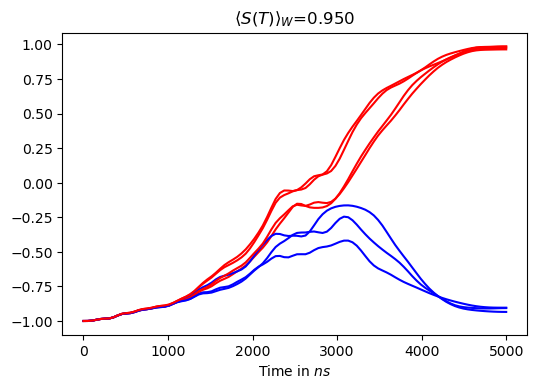

In [88]:
plot_av_occup(list_av_expect_from_dict(REGISTER_dict_opt))

In [89]:
T_quench = 12000
def seq_quench(reg,para):
    seq_q = interp_seq(reg,para)
    seq_q.add(Pulse.ConstantPulse(T_quench, 0.5 * 2*np.pi, 4 * 2*np.pi, 0.), 'ising')
    sim = Simulation(seq_q, sampling_rate=0.02)
    results = sim.run()
    expect_val = results.expect([occupation(j,N) for j in range(N)])
    stg_mag = sum([(-1)**j*expect_val[j] for j in range(1,N-1)])
    return stg_mag

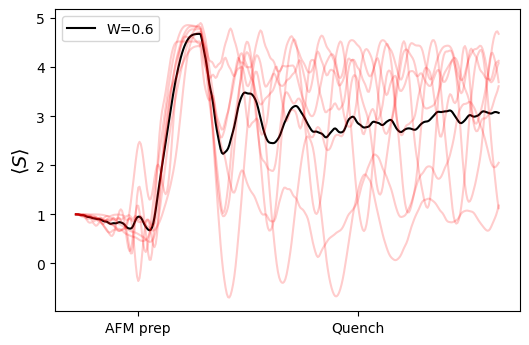

In [90]:
plt.figure()
plt.plot(np.mean([seq_quench(r['reg'],r['para']) for r in REGISTER_dict_opt.values()],axis=0),'k',label='W={}'.format(W))
for r in REGISTER_dict_opt.values():
    plt.plot(seq_quench(r['reg'],r['para']),'r',alpha=0.2)
plt.xticks([int(T*0.02/2),int((T+T_quench)*0.02/1.5)],['AFM prep','Quench'])
plt.ylabel(r'$\langle S\rangle$',fontsize=14)
plt.legend(loc=2)
plt.show()

In [154]:
register_dict_unopt, REGISTER_dict_opt = pulses_optimisation(15)

0.3055575307559959
0.18993449627106684
0.04639821298426683
0.3265343020987993
0.23138734540959915
0.2723654340728672
0.3020087941322639
0.01297372582230305
0.14277611708986215
0.19401326465103874
0.08844957234046957
0.28248368558132264
0.031870141560120246
0.37270131892402414
0.12098689967875109
Average run time:  200.79166666666666
4/15
0.21370434099349322
0.12678869610491694
0.07036433333345216
0.22914300734803028
0.2535652114590654
0.29909729496999027
0.14277611708986215
0.19401326465103874
0.28248368558132264
0.37270131892402414
0.12098689967875109
Average run time:  100.59943181818181
1/11
0.20156319232639175
0.07944178349789133
0.19516987884798598
0.19222188215750025
0.29909729496999027
0.04000424089158661
0.19401326465103874
0.2083844708756717
0.3402956779331444
0.12098689967875109
Average run time:  101.43125
2/10
0.20156319232639175
0.19516987884798598
0.1205511790988757
0.29909729496999027
0.19401326465103874
0.2083844708756717
0.24317763292374994
0.12098689967875109
Average 

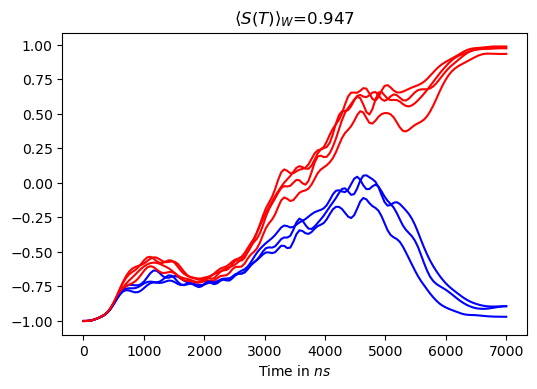

In [155]:
plot_av_occup(list_av_expect_from_dict(REGISTER_dict_opt))

4.7262787457345645


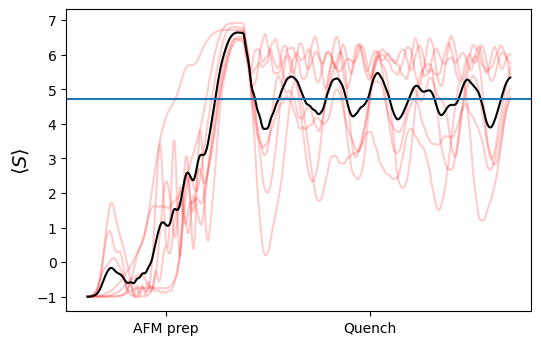

In [164]:
plt.figure()
for r in REGISTER_dict_opt.values():
    plt.plot(seq_quench(r['reg'],r['para']),'r',alpha=0.2)
plt.plot(np.mean([seq_quench(r['reg'],r['para']) for r in REGISTER_dict_opt.values()],axis=0),'k')
av_oscill = np.mean(np.mean([seq_quench(r['reg'],r['para']) for r in REGISTER_dict_opt.values()],axis=0)[int((T+T_quench)*0.02/2):])
print(av_oscill)
plt.axhline(y=av_oscill,color=)
plt.xticks([int(T*0.02/2),int((T+T_quench)*0.02/1.5)],['AFM prep','Quench'])
plt.ylabel(r'$\langle S\rangle$',fontsize=14)
plt.show()

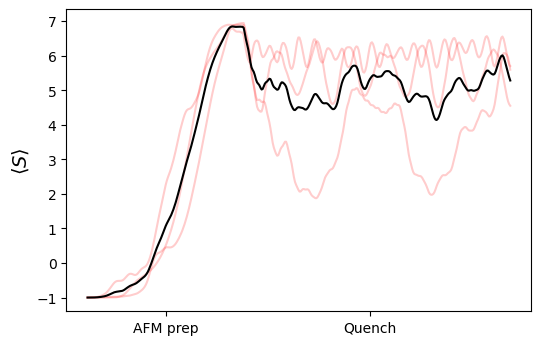

In [141]:
plt.figure()
for r in REGISTER_dict_opt.values():
    plt.plot(seq_quench(r['reg'],r['para']),'r',alpha=0.2)
plt.plot(np.mean([seq_quench(r['reg'],r['para']) for r in REGISTER_dict_opt.values()],axis=0),'k')
plt.xticks([int(T*0.02/2),int((T+T_quench)*0.02/1.5)],['AFM prep','Quench'])
plt.ylabel(r'$\langle S\rangle$',fontsize=14)
plt.show()

In [136]:
AF_state = qutip.tensor([qutip.basis(2,k%2) for k in range(N)])

In [137]:
bounds_quench = [(2000,12000)]+[(U_0*0.1,U_0*1.25)]+[(0.5*U_0,5*U_0)]
K = 100

def score_quench(para):
    RW = [reg(N,W) for k in range(K)]
    register_dict = {str(i):{'reg':RW[i][0],'W_list':RW[i][1]} for i in range(K)}
    T_quench, Omega, delta = para 
    av_S = 0
    for r in register_dict.values():
        seq_q = Sequence(r['reg'], Chadoq2)
        seq_q.declare_channel('ising', 'rydberg_global')
        seq_q.add(Pulse.ConstantPulse(T_quench, Omega, delta, 0.), 'ising')
        sim = Simulation(seq_q, sampling_rate=0.02)
        results = sim.run(initial_state=AF_state)
        expect_val = results.expect([occupation(j,N) for j in range(N)])
        stg_mag = sum([(-1)**j*expect_val[j] for j in range(1,N-1)])
        av_S += np.mean(stg_mag)
    return - av_S/K


In [ ]:
RESULT_quench = gp_minimize(score_quench,bounds_quench,n_random_starts = 30, n_calls = 70, initial_point_generator=lhs2,verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 32.2701
Function value obtained: -4.9679
Current minimum: -4.9679
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 11.2610
Function value obtained: -1.5585
Current minimum: -4.9679
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 23.6053
Function value obtained: -1.6168
Current minimum: -4.9679
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 11.1944
Function value obtained: -3.9537
Current minimum: -4.9679
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 36.6564
Function value obtained: -2.7180
Current minimum: -4.9679
Iteration No: 6 star

In [ ]:
quench_para = [12000,U_0*0.5,4*U_0]
score_quench(quench_para)

In [ ]:
print(RESULT_quench.x[0],'s')
print(RESULT_quench.x[1]/U_0)
print(RESULT_quench.x[2]/U_0)

In [ ]:
RW = [reg(N,W) for k in range(K)]
register_dict = {str(i):{'reg':RW[i][0],'W_list':RW[i][1]} for i in range(K)}

def stg_mag_after_quench(reg,para):
    T_quench, Omega, delta = para 
    for r in register_dict.values():
        seq_q = Sequence(reg, Chadoq2)
        seq_q.declare_channel('ising', 'rydberg_global')
        seq_q.add(Pulse.ConstantPulse(T_quench, Omega, delta, 0.), 'ising')
        sim = Simulation(seq_q, sampling_rate=0.02)
        results = sim.run(initial_state=AF_state)
        expect_val = results.expect([occupation(j,N) for j in range(N)])
        return sum([(-1)**j*expect_val[j] for j in range(1,N-1)])
av_S_0 = stg_mag_after_quench(REG,quench_para)
av_S =  np.mean([stg_mag_after_quench(r['reg'],quench_para) for r in register_dict.values()],axis=0)        
av_S_opt = np.mean([stg_mag_after_quench(r['reg'],RESULT_quench.x) for r in register_dict.values()],axis=0)        

In [ ]:
plt.figure()
plt.plot(np.linspace(0,RESULT_quench.x[0],int(0.02*RESULT_quench.x[0])),av_S_0,'b')
plt.plot(np.linspace(0,quench_para[0],int(0.02*quench_para[0])),av_S,'k')
plt.plot(np.linspace(0,RESULT_quench.x[0],int(0.02*RESULT_quench.x[0])),av_S_opt,'r')
plt.xticks()
plt.ylabel(r'$\langle S\rangle$',fontsize=14)
plt.show()